In [1]:
import matplotlib.pyplot as plt
import numpy as np
import vegas
import random as rand
import pickle as rick

alpha = 1 / 132.184
m_W = 80.379
m_Z = 91.1876
m_e = 0.511E-3
m_m = 105.66E-3
m_h = 125.1
e = (4 * np.pi * alpha) ** 0.5
cos = m_W / m_Z
sin = np.sqrt(1 - cos ** 2)
v = 2 * m_W * sin / e
Gam_Z = 2.4952
C_eB = 10 ** -10
C_eW = C_eB
C_eH = 10 ** -10
C_HB = 2 * 10 ** -10
C_HW = 10 ** -10
#Pick C_HD and C_HWB s.t. we can use the SM vev
C_HD = 10 ** -10
C_HWB = C_HD
C_AA = cos ** 2 * C_HB + sin ** 2 * C_HW - sin * cos * C_HWB
C_AZ = 2 * sin * cos * (C_HW - C_HB) - (cos ** 2 - sin ** 2) * C_HWB

def diff_decay2(s, t, ml, C_eB, C_eW, C_AA, C_AZ, C_eH, SW, CW):
    N = 1 / (32 * (2 * np.pi) ** 3  * m_h ** 3)
    u = m_h ** 2 + 2 * ml ** 2 - s - t
    struc_4 = (4 * e ** 2 * (m_h ** 4 + s ** 2)) / (t * u) #1/v^2
    
    f6_AA = (-64 * C_AA * ml ** 2 * m_W ** 2) / (v ** 2 * s * (t - ml ** 2) * (u - ml ** 2)) #1/v^2
    struc_6_AA = f6_AA * (-(t - ml ** 2) ** 3 - (u - ml ** 2) ** 3 + (t - ml ** 2) ** 2 * (u - ml ** 2) + (t - ml ** 2) * (u - ml ** 2) * (u - ml ** 2 - 4 * m_h ** 2) + 4 * ml ** 2 * (u + t - 2 * ml ** 2) ** 2)
    f8_AA = (64 * C_AA ** 2 * m_W ** 2 * SW ** 2) / s
    struc_8_AA = f8_AA * ((u - ml ** 2) ** 2 + (t - ml ** 2) ** 2)
    
    f6_AZ = ((-8 * C_AZ * ml ** 2 * m_W ** 2 * SW ** 2 * (CW ** 2 - 3 * SW ** 2)) / (SW * CW * v ** 2 * (u - ml ** 2) * (t - ml ** 2))) * ((m_Z ** 2 - Gam_Z ** 2 - s) / ((m_Z ** 2 - Gam_Z ** 2 - s) ** 2 + 4 * m_Z ** 2 * Gam_Z ** 2)) #1/v^2
    struc_6_AZ = f6_AZ * (-(t - ml ** 2) ** 3 - (u - ml ** 2) ** 3 + (t - ml ** 2) ** 2 * (u - ml ** 2) + (t - ml ** 2) * (u - ml ** 2) * (u - ml ** 2 - 4 * m_h ** 2) + 4 * ml ** 2 * (u + t - 2 * ml ** 2) ** 2)
    f8_AZ = (2 * C_AZ ** 2 * m_W ** 2) / (CW ** 2 * (Gam_Z ** 2 * m_Z ** 2 + (m_Z ** 2 - s) ** 2))
    struc_8_AZ = f8_AZ * (CW ** 4 - 2 * CW ** 2 * SW ** 2 + 5 * SW ** 4) * s * ((u - ml ** 2) ** 2 + (t - ml ** 2) ** 2)
    
    f8_AA_AZ = ((16 * C_AA * C_AZ * m_W ** 2 * SW * (1 - 4 * SW ** 2)) / (CW)) * ((m_Z ** 2 - Gam_Z ** 2 - s) / ((m_Z ** 2 - Gam_Z ** 2 - s) ** 2 + 4 * m_Z ** 2 * Gam_Z ** 2))
    struc_8_AA_AZ = f8_AA_AZ * ((u - ml ** 2) ** 2 + (t - ml ** 2) ** 2)
    
    f6_eH = (-16 * 2 ** 0.5 * ml * m_W ** 2 * SW ** 2 * C_eH) / (v * (u - ml ** 2) * (t - ml ** 2)) #1/v
    struc_6_eH = f6_eH * (2 * m_h ** 4 - 2 * m_h ** 2 * (u + t - 2 * ml ** 2) + (u + t - 2 * ml ** 2) ** 2)
    f8_eH = (8 * m_W ** 2 * SW ** 2 * v ** 2 * C_eH ** 2) / ((u - ml ** 2) * (t - ml ** 2)) #v^2
    struc_8_eH = f8_eH * (2 * m_h ** 4 - 2 * m_h ** 2 * (u + t - 2 * ml ** 2) + (u + t - 2 * ml ** 2) ** 2)
    
    f8_eBeW_o = 1 
    struc_8_eBeW_o = f8_eBeW_o * (- 16 * SW * m_h ** 2 * m_W * v * C_eH * (SW * C_eW - CW * C_eB)) #v
    
    struc_8_eBeW = 8 * (u - ml ** 2) * (t - ml ** 2) * (SW * C_eW - CW * C_eB) ** 2 
    
    f6_eBeW = (m_h ** 2 * m_W * SW * ml) / (v ** 2) #1/v^2
    struc_6_eBeW = f6_eBeW * (16 * 2 ** 0.5 + (8 * 2 ** 0.5 * ml * CW) / (u)) * (SW * C_eW - CW * C_eB)
    
    return np.concatenate((N * (ml / v) ** 2 * np.array([struc_4]), N * np.array([struc_6_AA, struc_6_AZ, struc_6_eH, struc_6_eBeW]), N * np.array([struc_8_AA, struc_8_AZ, struc_8_eH, struc_8_AA_AZ, struc_8_eBeW, struc_8_eBeW_o])), axis=0)

def d_t(m, x):
    return (m_h ** 2 - x) * (1 - 4 * (m ** 2 / x)) ** 0.5

def t_max(s, m):
    return 0.5 * (m_h ** 2 - s + 2 * m ** 2 + (m_h ** 2 - s) * (1 - (4 * m ** 2) / s) ** 0.5) 

def t_min(s, m):
    return 0.5 * (m_h ** 2 - s + 2 * m ** 2 - (m_h ** 2 - s) * (1 - (4 * m ** 2) / s) ** 0.5) 

def s_func_max(m, t):
    return (-t**2+m_h**2*t+2*m**2*t+m_h**2*m**2-m**4+(t**4-2*m_h**2*t**3-4*m**2*t**3+m_h**4*t**2
    +6*m**4*t**2+2*m_h**2*m**2*t**2-4*m**6*t+2*m_h**2*m**4*t-2*m_h**4*m**2*t+m**8-2*m_h**2*m**6+m_h**4*m**4)**0.5)/(2*t)

def s_func_min(m, t):
    return (-t**2+m_h**2*t+2*m**2*t+m_h**2*m**2-m**4-(t**4-2*m_h**2*t**3-4*m**2*t**3+m_h**4*t**2
    +6*m**4*t**2+2*m_h**2*m**2*t**2-4*m**6*t+2*m_h**2*m**4*t-2*m_h**4*m**2*t+m**8-2*m_h**2*m**6+m_h**4*m**4)**0.5)/(2*t)

def E_l(m, u):
    return (m_h ** 2 + m ** 2 - u) / (2 * m_h)

def E_lbar(m, t):
    return (m_h ** 2 + m ** 2 - t) / (2 * m_h)

def E_phot(m, s):
    return (m_h ** 2 - s) / (2 * m_h)

def mom_l(E, m):
    mod = (E ** 2 - m ** 2) ** 0.5
    vec = mod * np.array([0, 0, 1])
    return vec

def mom_lbar(E_m, E_p, m, s, phi):
    mod = (E_p ** 2 - m ** 2) ** 0.5
    cos_th  = (m ** 2 + E_m * E_p - 0.5 * s) / ((E_m ** 2 - m ** 2) * (E_p ** 2 - m ** 2)) ** 0.5
    sin_th = (1 - cos_th ** 2) ** 0.5
    vec = mod * np.array([sin_th * np.cos(phi), sin_th * np.sin(phi), cos_th])
    return vec

def mom_phot(p_mvec, p_pvec):
    return - p_mvec - p_pvec

def cos_ll(m, E_u, E_t, s):
    n = m ** 2 + E_u * E_t - 0.5 * s
    d = (E_u ** 2 - m ** 2) ** 0.5 * (E_t ** 2 - m ** 2) ** 0.5
    return n / d

def cos_lk(m, E_u, E_s, t):
    n = m ** 2 - t + 2 * E_u * E_s
    d = 2 * E_s * (E_u ** 2 - m ** 2) ** 0.5 
    return n / d

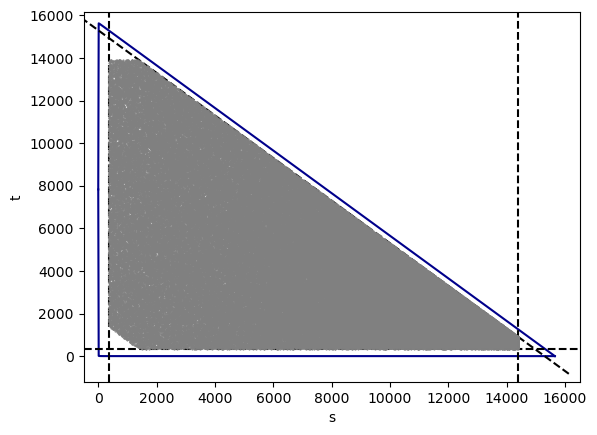

In [10]:
m = m_m
k = 0.15
E_phot_min = 5
s_min_fix = 4 * m ** 2
s_max_fix = m_h ** 2
t_min_fix = m ** 2
t_max_fix = (m_h - m) ** 2

ss = []
ts = []
srej = []
trej = []
for i in range(0, 200000):
    x_0 = rand.random()
    x_1 = rand.random()
    s_subs = s_min_fix + (s_max_fix - s_min_fix) * x_1
    t_subs = t_min(s_subs, m) + (t_max(s_subs, m) - t_min(s_subs, m)) * x_0
    u = m_h ** 2 + 2 * m ** 2 - s_subs - t_subs
    if m_h ** 2 - 2 * m_h * E_phot_min >= s_subs >= (k * m_h) ** 2 and u >= (k * m_h) ** 2 and t_subs >= (k * m_h) ** 2 and E_phot(m, s_subs) > 5 and ((E_l(m, u) > 25 and E_lbar(m, t_subs) > 7) or (E_lbar(m, t_subs) > 25 and E_l(m, u) > 7)):
        ts += [t_subs]
        ss += [s_subs]
    else:
        trej += [t_subs]
        srej += [s_subs]
        
def line(m, s, u_fix):
    return m_h ** 2 + 2 * m ** 2 - s - u_fix

def line2(m, t, u_fix):
    return m_h ** 2 + 2 * m ** 2 - t - u_fix
 
s_plot_min = -500
s_plot_max = 16500
t_plot_min = line(m, s_plot_max, (k * m_h) ** 2)
t_plot_max = line(m, s_plot_min, 0)
    
tp = np.linspace(m ** 2, (m_h - m) ** 2, 1000)
sp = np.linspace(4 * m ** 2, m_h ** 2, 1000)
s_u = np.linspace(s_plot_min, s_plot_max, 10)
t_u = np.linspace(t_plot_min, t_plot_max, 10)

plt.plot(sp, t_max(sp, m), color = 'darkblue')
plt.plot(sp, t_min(sp, m), color = 'darkblue')
#plt.plot(s_u, line(m, s_u, (k * m_h) ** 2), color = 'black', linestyle = 'dashed')
plt.plot(t_u, line2(m, t_u, (k * m_h) ** 2), color = 'black', linestyle = 'dashed')
plt.axvline((k * m_h) ** 2, color = 'black', linestyle = 'dashed')
plt.axhline((k * m_h) ** 2, color = 'black', linestyle = 'dashed')
plt.axvline(m_h ** 2 - 2 * m_h * E_phot_min, color = 'black', linestyle = 'dashed')

plt.ylim(t_plot_min, t_plot_max)
plt.xlim(s_plot_min, s_plot_max)
plt.xlabel('s')
plt.ylabel('t')
plt.plot(ss, ts, marker = '.', markersize = 1, ls = 'None', alpha = 1, color = 'gray')
plt.show()

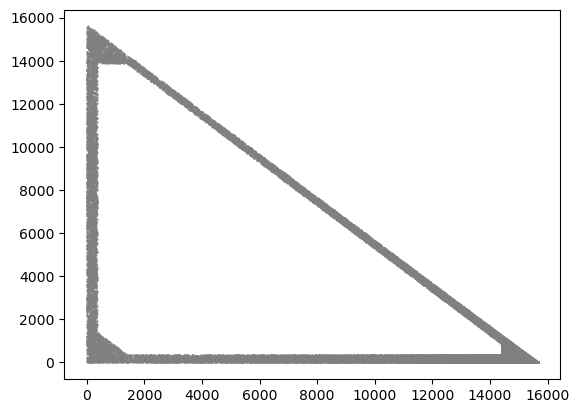

In [14]:
plt.plot(srej, trej, marker = '.', markersize = 1, ls = 'None', alpha = 1, color = 'gray')
plt.show()

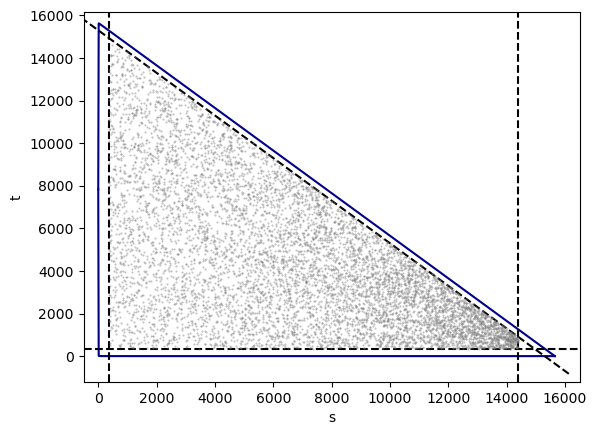

In [32]:
m = m_m
k = 0.15
E_phot_min = 5
s_min_fix = 4 * m ** 2
s_max_fix = m_h ** 2
t_min_fix = m ** 2
t_max_fix = (m_h - m) ** 2

ss = []
ts = []
for i in range(0, 10000):
    x_0 = rand.random()
    x_1 = rand.random()
    s_subs = s_min_fix + (s_max_fix - s_min_fix) * x_1
    t_subs = t_min(s_subs, m) + (t_max(s_subs, m) - t_min(s_subs, m)) * x_0
    u = m_h ** 2 + 2 * m ** 2 - s_subs - t_subs
    if m_h ** 2 - 2 * m_h * E_phot_min >= s_subs >= (k * m_h) ** 2 and u >= (k * m_h) ** 2 and t_subs >= (k * m_h) ** 2 and E_phot(m, s_subs) > 5:
        ts += [t_subs]
        ss += [s_subs] 

def line(m, s, u_fix):
    return m_h ** 2 + 2 * m ** 2 - s - u_fix

def line2(m, t, u_fix):
    return m_h ** 2 + 2 * m ** 2 - t - u_fix
 
s_plot_min = -500
s_plot_max = 16500
t_plot_min = line(m, s_plot_max, (k * m_h) ** 2)
t_plot_max = line(m, s_plot_min, 0)
    
tp = np.linspace(m ** 2, (m_h - m) ** 2, 1000)
sp = np.linspace(4 * m ** 2, m_h ** 2, 1000)
s_u = np.linspace(s_plot_min, s_plot_max, 10)
t_u = np.linspace(t_plot_min, t_plot_max, 10)

plt.plot(sp, t_max(sp, m), color = 'darkblue')
plt.plot(sp, t_min(sp, m), color = 'darkblue')
#plt.plot(s_u, line(m, s_u, (k * m_h) ** 2), color = 'black', linestyle = 'dashed')
plt.plot(t_u, line2(m, t_u, (k * m_h) ** 2), color = 'black', linestyle = 'dashed')
plt.axvline((k * m_h) ** 2, color = 'black', linestyle = 'dashed')
plt.axhline((k * m_h) ** 2, color = 'black', linestyle = 'dashed')
plt.axvline(m_h ** 2 - 2 * m_h * E_phot_min, color = 'black', linestyle = 'dashed')

plt.ylim(t_plot_min, t_plot_max)
plt.xlim(s_plot_min, s_plot_max)
plt.xlabel('s')
plt.ylabel('t')
plt.plot(ss, ts, marker = '.', markersize = 1, ls = 'None', alpha = 0.5, color = 'gray')
plt.show()

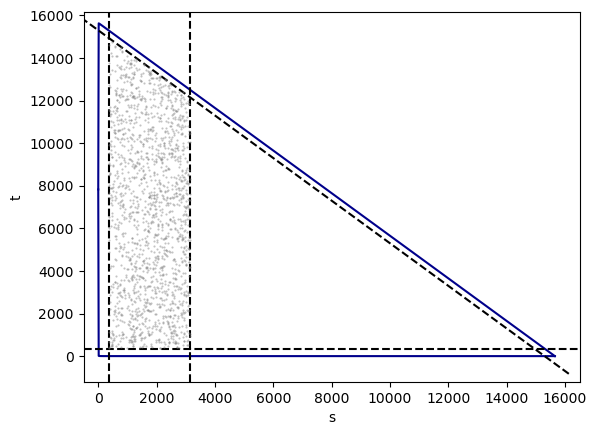

In [30]:
m = m_m
k = 0.15
E_phot_min = 50
s_min_fix = 4 * m ** 2
s_max_fix = m_h ** 2
t_min_fix = m ** 2
t_max_fix = (m_h - m) ** 2

ss = []
ts = []
for i in range(0, 10000):
    x_0 = rand.random()
    x_1 = rand.random()
    s_subs = s_min_fix + (s_max_fix - s_min_fix) * x_1
    t_subs = t_min(s_subs, m) + (t_max(s_subs, m) - t_min(s_subs, m)) * x_0
    u = m_h ** 2 + 2 * m ** 2 - s_subs - t_subs
    if m_h ** 2 - 2 * m_h * E_phot_min >= s_subs >= (k * m_h) ** 2 and u >= (k * m_h) ** 2 and t_subs >= (k * m_h) ** 2:
        ts += [t_subs]
        ss += [s_subs] 

def line(m, s, u_fix):
    return m_h ** 2 + 2 * m ** 2 - s - u_fix

def line2(m, t, u_fix):
    return m_h ** 2 + 2 * m ** 2 - t - u_fix
 
s_plot_min = -500
s_plot_max = 16500
t_plot_min = line(m, s_plot_max, (k * m_h) ** 2)
t_plot_max = line(m, s_plot_min, 0)
    
tp = np.linspace(m ** 2, (m_h - m) ** 2, 1000)
sp = np.linspace(4 * m ** 2, m_h ** 2, 1000)
s_u = np.linspace(s_plot_min, s_plot_max, 10)
t_u = np.linspace(t_plot_min, t_plot_max, 10)

plt.plot(sp, t_max(sp, m), color = 'darkblue')
plt.plot(sp, t_min(sp, m), color = 'darkblue')
#plt.plot(s_u, line(m, s_u, (k * m_h) ** 2), color = 'black', linestyle = 'dashed')
plt.plot(t_u, line2(m, t_u, (k * m_h) ** 2), color = 'black', linestyle = 'dashed')
plt.axvline((k * m_h) ** 2, color = 'black', linestyle = 'dashed')
plt.axhline((k * m_h) ** 2, color = 'black', linestyle = 'dashed')
plt.axvline(m_h ** 2 - 2 * m_h * E_phot_min, color = 'black', linestyle = 'dashed')

plt.ylim(t_plot_min, t_plot_max)
plt.xlim(s_plot_min, s_plot_max)
plt.xlabel('s')
plt.ylabel('t')
plt.plot(ss, ts, marker = '.', markersize = 1, ls = 'None', alpha = 0.5, color = 'gray')
plt.show()